In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [6]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="document", 
                               column_summary="summary"):
    document_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip( document_batches, target_batches), total=len( document_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [7]:
dataset = load_dataset("multi_news", ignore_verifications=True)

split_lengths = [len(dataset[split])for split in dataset]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset['train'].column_names}")


d:\anaconda3\Lib\site-packages\datasets\load.py:2097: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Split lengths: [6548, 5622, 5622]
Features: ['document', 'summary']


In [8]:
print("\nSummary:")

print(dataset["test"][4]["document"])

print("\nSummary:")

print(dataset["test"][4]["summary"])


Summary:
After a year in which liberals scored impressive, high-profile Supreme Court victories, conservatives could be in line for wins on some of this term's most contentious issues, as the justices consider cases that could gut public sector labor unions and roll back affirmative action at state universities. 
 
 However, as the court's new term kicks off Monday, uncertainty surrounds several other politically potent cases that could wind up on the court’s agenda. 
 
 Story Continued Below 
 
 Litigation over state efforts to limit abortion by regulating clinics and doctors is making its way to the high court. And the justices are already facing a batch of petitions involving the rights of religious institutions to opt out of providing contraception under Obamacare. 
 
 Both issues seem likely to land on this term's docket, although the justices haven’t formally taken up either. 
 
 Many in the Obama administration would also like to see the court weigh in on immigration in coming 

In [13]:
print("\nSummary:")

print(dataset["train"][4]["document"])

print("\nSummary:")

print(dataset["train"][4]["summary"])


Summary:
A man accused of removing another man's testicle during a meeting in a Port Macquarie motel room has pleaded guilty to a string of charges. 
 
 Allan George Matthews, 57, appeared in Port Macquarie Local Court on Wednesday morning for the first time since his arrest in Glen Innes, last month. 
 
 SHARE 
 
 Share on Facebook SHARE 
 
 Share on Twitter TWEET 
 
 Link A man has pleaded guilty after 'unauthorised' surgery to remove another's testicle. 
 
 During the proceedings, Matthews' solicitor Douglas Hannaway entered pleas of guilty to removing tissue from the body of another without consent or authority. 
 
 He has pleaded not guilty to the more serious charge of reckless grievous bodily harm. 
 
 Magistrate Dominique Burns ordered police to compile a brief of evidence by next month and serve it on Matthews' defence before it returns to court in mid-August. 
 
 The charges stem from an incident in a motel room in Port Macquarie on May 16. 
 
 Advertisement 
 
 Police alleg

# Evaluating PEGASUS on SAMSum

In [9]:
dataset['test'][3]['document']

'The seed for this crawl was a list of every host in the Wayback Machine \n \n This crawl was run at a level 1 (URLs including their embeds, plus the URLs of all outbound links including their embeds) \n \n The WARC files associated with this crawl are not currently available to the general public. ||||| Summary: Microsoft\'s acquisition of Nokia is aimed at building a devices and services strategy, but the joint company won\'t take the same form as Apple. \n \n Microsoft has been working on its evolution into a devices and services company, away from the services business it has traditionally been, for several years now with limited success. \n \n Its acquisition of most of Nokia is the latest acceleration of that strategy — to move further away from the moribund world of the beige desktop and towards the sunlit world of smartphones and tablets. \n \n Owning the desktop (via Windows) and building additional services on top, like Office or search, has been vital for Microsoft\'s strate

In [10]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset['test'][4]['document'] )

print(pipe_out)

Token indices sequence length is longer than the specified maximum sequence length for this model (3952 > 512). Running this sequence through the model will result in indexing errors


[{'summary_text': "the new term's biggest rulings will land in the middle of the 2016 presidential race . the court has not been friendly to the justices, but a similar case in the state . it's unclear whether the court will be able to weigh in on immigration ."}]


In [11]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

the new term's biggest rulings will land in the middle of the 2016 presidential race . the court has not been friendly to the justices, but a similar case in the state . it's unclear whether the court will be able to weigh in on immigration .


In [12]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset['test'], rouge_metric, model, tokenizer, column_text = 'document', column_summary='summary', batch_size=8)

C:\Users\Dell\AppData\Local\Temp\ipykernel_10616\1051429460.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
  0%|          | 0/703 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [13]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['t5'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015558,0.000295,0.015537,0.01554


# Histogram

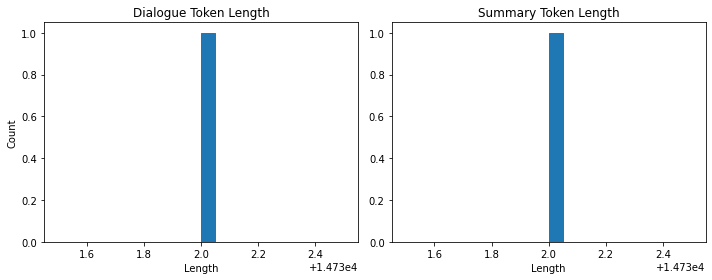

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset['train']['document']])

summary_token_len = len([tokenizer.encode(s) for s in dataset['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [13]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['document'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_multinews_pt = dataset.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/5622 [00:00<?, ? examples/s]

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:3619: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [14]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
%cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM


In [15]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='datasets', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

In [29]:
pip install pathtools

  Using cached pathtools-0.1.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [41]:

!pip install --upgrade wandb



                                              0.0/2.2 MB ? eta -:--:--
                                              0.0/2.2 MB ? eta -:--:--
                                              0.0/2.2 MB 495.5 kB/s eta 0:00:05
     -                                        0.1/2.2 MB 751.6 kB/s eta 0:00:03
     ---                                      0.2/2.2 MB 984.6 kB/s eta 0:00:03
     ----                                     0.2/2.2 MB 1.1 MB/s eta 0:00:02
     -----                                    0.3/2.2 MB 1.1 MB/s eta 0:00:02
     -----                                    0.3/2.2 MB 1.1 MB/s eta 0:00:02
     ------                                   0.4/2.2 MB 1.1 MB/s eta 0:00:02
     --------                                 0.4/2.2 MB 1.1 MB/s eta 0:00:02
     ---------                                0.5/2.2 MB 1.1 MB/s eta 0:00:02
     ---------                                0.5/2.2 MB 1.2 MB/s eta 0:00:02
     -----------                              0.6/2.2 MB 1.2 MB/s eta 0:

In [16]:

trainer = Trainer(model=model, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_multinews_pt["train"], 
                  eval_dataset=dataset_multinews_pt["validation"])

In [18]:
trainer.train()


  0%|          | 0/409 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyboardInterrupt: 

In [30]:
score = calculate_metric_on_test_ds(
    dataset['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'document', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f't5'] )

100%|██████████| 410/410 [13:08<00:00,  1.92s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018618,0.000297,0.018493,0.018518


In [22]:
## Save model
model.save_pretrained("t5-model-summary-multinews")

Configuration saved in pegasus-samsum-model/config.json
Model weights saved in pegasus-samsum-model/pytorch_model.bin


In [23]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

tokenizer config file saved in tokenizer/tokenizer_config.json
Special tokens file saved in tokenizer/special_tokens_map.json


('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [24]:
dataset_samsum = load_dataset("samsum")

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

loading file spiece.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


In [27]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [28]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

loading configuration file pegasus-samsum-model/config.json
Model config PegasusConfig {
  "_name_or_path": "pegasus-samsum-model",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "l

In [29]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
